In [67]:
import os

import pandas as pd

def add_protein_column(Condition, a):
    plasmid_name = Condition.split('_')[a]
    protein = plasmid_to_protein.get(plasmid_name, None)

    if (protein=='PerMn1')*(Condition.split('_')[3]=='0'):
        protein = protein + ' uninduced'
    
    if protein:
        return protein
    else:
        return None

# Find all *tracks.xml files in subdirectories
rootFolderPath = '/home/zach/Desktop/microscope_data/FtsB_tracking/'

n = 0

dates = []
filepaths = []
conditions = []
image_file = []
iptg=[]
fp=[]

for root, dirs, files in os.walk(rootFolderPath):
    for filename in files:
        if filename[-10:] == 'tracks.xml':
            filepath = os.path.join(root, filename)
            if filepath.split('/')[7][0] != '0': # exclude one experiment imaging sooner after preparing sample
                filepaths.append(filepath)
                dates.append(filepath.split('/')[6].split(' ')[0])
                conditions.append(filepath.split('/')[7][0:])
                image_file.append(filepath.split('/')[9].split('_')[0])
                iptg.append(filepath.split('/')[7].split('_')[3])

                if image_file[-1][0:3] == '514':
                    fp.append('mNeonGreen')
                else:
                    fp.append('mEos3.2')
                
                n += 1

df = pd.DataFrame(data = {'Date':dates, 'Path':filepaths, 'Condition':conditions,'Image file':image_file,'IPTG': iptg, 'FP': fp}).sort_values(by=['Date', 'Condition', 'Image file'])
df.drop(df[(df['FP'] == 'mNeonGreen')*(df['IPTG'] == "0")].index, inplace = True)

plasmid_to_protein = { 'pJRF004n1':'PerMn1',
                      'pLG906':'FtsBΔLQΔH',
                      'pZH904':'FtsBΔLQ',
                      'pJRF010':'Pf3'}

df['Protein1'] = df['Condition'].apply(add_protein_column, a = 1)
df['Protein2'] = df['Condition'].apply(add_protein_column, a = 2)
df['Proteins'] = df['Protein1'] + ' ' + df['Protein2']
df['Tracks'] = [ [] for i in range(len(df)) ]

In [78]:
# Load in all track xml files from TrackMate analysis

import numpy as np
import matplotlib.pylab as plt
from os import path
from xml.dom import minidom
from IPython.display import clear_output

def import_track_xml(filepath):
  tracks = []
  file_data = minidom.parse(filepath)

  for track in file_data.getElementsByTagName("particle"):
    detections = track.getElementsByTagName("detection")
    numSpots = len(detections)
    track_xy = np.empty([numSpots, 2], dtype=float)
    for i in range(numSpots):
      track_xy[i][0] = detections[i].getAttribute("x")
      track_xy[i][1] = detections[i].getAttribute("y")

    # Add track if all points are at least 1000 nm (10 pixels) from edge of image
    if np.min([track_xy[:][0], track_xy[:][1], 25600 - track_xy[:][0], 25600 - track_xy[:][1]]) > 500:
        tracks.append(track_xy)

  return(tracks)

def add_tracks(filepath):
    global i
    clear_output(wait=True)
    i += 1
    print('Loading',filepath)
    print('File',i,'of',len(df))
    tracks = import_track_xml(filepath)
    print(len(tracks),'tracks loaded')
    return tracks

i = 0
df['Tracks'] = df['Path'].apply(add_tracks)

Loading /home/zach/Desktop/microscope_data/FtsB_tracking/231012 PALM PerM FtsB/5_pJRF010_pLG906_240_uM/mEos3.2_PALM/PALM05_tracks.xml
File 115 of 115
2239 tracks loaded


In [79]:
#@title Make image masks

from scipy.ndimage import gaussian_filter,maximum_filter
import scipy

def add_mask(spotMedians):
    global i
    clear_output(wait=True)
    i += 1
    
    print('Making masks for file',i,'of',len(df))

    maskImage = gaussian_filter(spotMedians, gaussian_sigma)
    maskImage = maskImage > threshold
    maskImage = maximum_filter(maskImage, size=maxFilterSize)
    maskImage[0:borderMask,:] = maskImage[:,0:borderMask] = maskImage[-borderMask:,:] = maskImage[:,-borderMask:] = 1
    
    return maskImage

gaussian_sigma =1.5 # pixels to blur
threshold = 2 # threshold of number of trajectories w/ median coordinate in pixel after blur
resolution = 100; # nm/pixel
maxFilterSize = 2;
borderMask = 5; # number of pixels to exclude on border

df['maskImage'] = [ np.zeros((256,256)) for i in range(len(df)) ]
df['spotMedians'] = [ np.zeros((256,256)) for i in range(len(df)) ]
spotMedians = np.zeros((len(files),256,256))

medIdx = df.columns.get_loc('spotMedians')

i = 0
for f in range(len(df)):
  i += 1
  clear_output(wait=True)
  print('Median spots for file',i,'of',len(df))
    
  for trajectory in df.iloc[f].Tracks:
    medCoordinate = np.int_(np.floor(np.median(trajectory,axis=0) / resolution))
    df.iloc[f,medIdx][medCoordinate[1],medCoordinate[0]] = df.iloc[f]['spotMedians'][medCoordinate[1],medCoordinate[0]] + 1

i = 0
df['maskImage'] = df['spotMedians'].apply(add_mask)

Making masks for file 115 of 115


In [80]:
# Calculate displacement data for all experiments on all days individually

def calculate_mean_square_displacement(file, minimum_trajectory_spots=2, maximum_trajectory_spots=21, mask_too_dense_spots=True, 
                                       maskImages=None, resolution=100, maximum_points_per_trajectory=10):
    global i
    clear_output(wait=True)
    i += 1
    print('Calculating msds for',i,'of',len(df))

    traj_lengths = np.array([len(trajectory) for trajectory in file])
    max_length = traj_lengths.max()

    if max_length > maximum_trajectory_spots:
        max_length = traj_lengths[traj_lengths <= maximum_trajectory_spots].max()

    sds = [[] for _ in range(1, max_length)]
    all_displacements = np.empty(0)
    
    for trajectory in file:
        
        if len(trajectory) >= minimum_trajectory_spots and len(trajectory) <= maximum_trajectory_spots:
            use_trajectory = 1
    
            if mask_too_dense_spots and maskImages is not None:
                medCoordinate = np.int_(np.floor(np.median(trajectory, axis=0) / resolution))
                if maskImages[i, medCoordinate[1], medCoordinate[0]]:
                    use_trajectory = 0
    
            if use_trajectory:
                maxJ = np.min([maximum_points_per_trajectory, len(trajectory) - 1])
                displacements = (trajectory[1:, :] - trajectory[0, :]) / 1e3
                all_displacements = np.sqrt(np.sum(((trajectory[1:, :] - trajectory[0:-1, :]) / 1e3) ** 2, axis=1))
    
                for j in range(maxJ):
                    traj_sds = np.sum(displacements ** 2, axis=1)
                    for t in range(len(traj_sds)):
                        sds[t].append(traj_sds[t])
                    displacements = displacements[1:,:]-displacements[0,:]

    mean_square_displacement = np.array([np.mean(x) for x in sds])
    error_bar = np.array([np.std(x)/np.sqrt(len(x)) for x in sds])
    measurement = np.array([len(x) for x in sds])

    return mean_square_displacement, error_bar, measurement, sds

i = 0
df[['msd', 'msd_error', 'msd_N', 'sds']] = df.apply(lambda row: calculate_mean_square_displacement(row.Tracks), axis=1, result_type="expand")

Calculating msds for 115 of 115


In [77]:
def add_tracks(filepath):
    global i
    clear_output(wait=True)
    i += 1
    print('Loading',filepath)
    print('File',i,'of',len(df))
    tracks = import_track_xml(filepath)
    print(len(tracks),'tracks loaded')
    return tracks

test = add_tracks(df.iloc[109].Path)
test
# df.iloc[109]

Loading /home/zach/Desktop/microscope_data/FtsB_tracking/231012 PALM PerM FtsB/5_pJRF010_pLG906_240_uM/mNeonGreen_514/514_mNG_stream01_tracks.xml
File 122 of 115
0 tracks loaded


[]

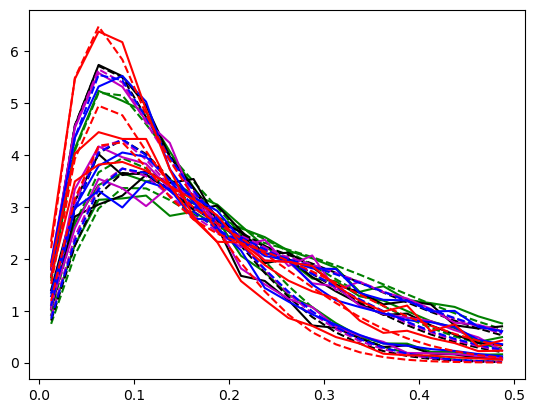

In [81]:
# calculate probability density for displacements P(r,t) and fit for all experiments on all days individually

from scipy import optimize
import scipy.stats as stats

# Function to fit MSD (Matsuoka 2009 via Spot-On paper)

# P(r,t) = ( r / ( 2*(D*t + s^2) ) ) * exp ( -r^2 / (4 * (D*t + s^2) ) )
# For effective 1D diffusion we will change 4 above to 2
# Additionally, return with rows divided by their sum

def normalized_1D_diffusion(rt, D, s):
    r, t = rt
    P = ( r / (2*D*t + 2*s**2) ) * np.exp( -r**2 / (4*D*t + 4*s**2))
    # P = ( r / (2 * D * t + 2*s**2) ) * np.exp( -r**2 / (4* D * t + 4*s**2))
    
    for ti in np.unique(t):

        N = P[t==ti].sum()
        P[t==ti] = P[t==ti] / N
    
    return P

def normalized_two_pop_diffusion(rt, F1, D1, D2, s):
    r, t = rt
    # P = F1 * ( r / (np.sqrt(D1 * t + s**2)) ) * np.exp( -r**2 / (2*(D1 * t + s**2))) \
    #     + (1 - F1) * ( r / (np.sqrt(D2 * t + s**2)) ) * np.exp( -r**2 / (2*(D2 * t + s**2)))

    P = F1 * ( r / (2*D1*t + 2*s**2) ) * np.exp( -r**2 / (4*D1*t + 4*s**2)) \
        + (1 - F1) * ( r / (2*D2*t + 2*s**2) ) * np.exp( -r**2 / (4*D2*t + 4*s**2))

    P = F1 * ( r / (D1*t + 2*s**2) ) * np.exp( -r**2 / (2*D1*t + 4*s**2)) \
        + (1 - F1) * ( r / (D2*t + 2*s**2) ) * np.exp( -r**2 / (2*D2*t + 4*s**2))
    
    for ti in np.unique(t):

        N = P[t==ti].sum()
        P[t==ti] = P[t==ti] / N
    
    return P



max_fit_jump = 0.5 # max jump to consider in microns
bin_width = 0.025 # bin width in microns
max_fit_tau = 3 # max number of jumps to consider when fitting
dt = 0.033 # time between frames
use_kde = False
fit_two_populations = True

n_bins = np.floor(max_fit_jump/bin_width).astype(int)
bins = np.linspace(0., max_fit_jump, n_bins+1)

r = bins[1:] - bin_width/2
t = dt*(1 + np.arange(max_fit_tau))
rr, tt = np.meshgrid(r, t)
rt = (rr.ravel(), tt.ravel())

# First: add probability density to dataframe for each row from square displacements

plot_data = []

# arrays to be filled in
params = [None] * len(df)
pcov = [None] * len(df)

cs = 'rgbkmc'

pcs = {}
i = 0

for p in df.Proteins.unique():
    
    pcs[p] = cs[i]
    i += 1

for i in range(len(df)):

    plotme = np.random.random()

    plot_data.append(np.zeros([n_bins,max_fit_tau]))

    for j in range(max_fit_tau):

        j_data = np.sqrt(df.iloc[i].sds[j])

        if use_kde:
            density = stats.gaussian_kde(j_data)
            plot_data[i][:,j] = density(r)
        else:
            plot_data[i][:,j], _ = np.histogram(j_data,bins)

        # normalize separately for each tau
        plot_data[i][:,j] = plot_data[i][:,j]/plot_data[i][:,j].sum()

        if plotme < .05:
            plt.plot(r,plot_data[i][:,j]/bin_width,pcs[df.iloc[i].Proteins])

    # normalized_two_pop_diffusion(rt, F1, D1, D2, s):
    
    # Fit data
    guess = (0.3, 0.05195) # guess D in microns^2/s and fit error, s, in microns

    if fit_two_populations:
        # bounds = ([0,0,0.2,0.051949],[1,0.2,np.inf,0.051951])
        bounds = ([0,0,0.2,0.0],[1,0.2,np.inf,np.inf])
        params[i], pcov[i] = optimize.curve_fit(normalized_two_pop_diffusion, rt, plot_data[i].T.ravel(),
                                        p0=[0.5, guess[0]/2, guess[0]*2, guess[1]], bounds=bounds)
        
        for j in range(max_fit_tau):
            
            rt_plot = np.c_[r,dt*(j+1)*np.ones(n_bins)].T
            if plotme < .05:
                #params[i][3] = 0
                plt.plot(r,normalized_two_pop_diffusion(rt_plot,params[i][0],params[i][1],params[i][2],params[i][3])/bin_width,pcs[df.iloc[i].Proteins] + '--')
    else:
        params[i], pcov[i] = optimize.curve_fit(normalized_1D_diffusion, rt, plot_data[i].T.ravel(),
                                            p0=guess, bounds=(0,np.inf))
        
        for j in range(max_fit_tau):
            
            rt_plot = np.c_[r,dt*(j+1)*np.ones(n_bins)].T
            if plotme < 0.05:
                plt.plot(r,normalized_1D_diffusion(rt_plot,params[i][0],params[i][1])/bin_width,pcs[df.iloc[i].Proteins] + '--')
                if j==0:
                    print(params[i])
            
plt.show()

In [ ]:
# calculate probability density for displacements P(r,t) and fit for all experiments on all days individually

from scipy import optimize
import scipy.stats as stats

# Function to fit MSD (Matsuoka 2009 via Spot-On paper)

# P(r,t) = ( r / ( 2*(D*t + s^2) ) ) * exp ( -r^2 / (4 * (D*t + s^2) ) )
# For effective 1D diffusion we will change 4 above to 2
# Additionally, return with rows divided by their sum

def normalized_1D_diffusion(rt, D, s):
    r, t = rt
    P = ( r / (2*D*t + 2*s**2) ) * np.exp( -r**2 / (4*D*t + 4*s**2))
    # P = ( r / (2 * D * t + 2*s**2) ) * np.exp( -r**2 / (4* D * t + 4*s**2))
    
    for ti in np.unique(t):

        N = P[t==ti].sum()
        P[t==ti] = P[t==ti] / N
    
    return P

def normalized_two_pop_diffusion(rt, F1, D1, D2, s):
    r, t = rt
    # P = F1 * ( r / (np.sqrt(D1 * t + s**2)) ) * np.exp( -r**2 / (2*(D1 * t + s**2))) \
    #     + (1 - F1) * ( r / (np.sqrt(D2 * t + s**2)) ) * np.exp( -r**2 / (2*(D2 * t + s**2)))

    P = F1 * ( r / (2*D1*t + 2*s**2) ) * np.exp( -r**2 / (4*D1*t + 4*s**2)) \
        + (1 - F1) * ( r / (2*D2*t + 2*s**2) ) * np.exp( -r**2 / (4*D2*t + 4*s**2))

    P = F1 * ( r / (D1*t + 2*s**2) ) * np.exp( -r**2 / (2*D1*t + 4*s**2)) \
        + (1 - F1) * ( r / (D2*t + 2*s**2) ) * np.exp( -r**2 / (2*D2*t + 4*s**2))
    
    for ti in np.unique(t):

        N = P[t==ti].sum()
        P[t==ti] = P[t==ti] / N
    
    return P

df2 = df.query('FP=="mNeonGreen"')
plotDates = df2.Date.unique().tolist()

max_fit_jump = 0.5 # max jump to consider in microns
bin_width = 0.025 # bin width in microns
max_fit_tau = 3 # max number of jumps to consider when fitting
dt = 0.033 # time between frames
use_kde = False
fit_two_populations = True

n_bins = np.floor(max_fit_jump/bin_width).astype(int)
bins = np.linspace(0., max_fit_jump, n_bins+1)

r = bins[1:] - bin_width/2
t = dt*(1 + np.arange(max_fit_tau))
rr, tt = np.meshgrid(r, t)
rt = (rr.ravel(), tt.ravel())

# First: add probability density to dataframe for each row from square displacements

plot_data = []

# arrays to be filled in
params = [None] * len(plotDates)
pcov = [None] * len(plotDates)

cs = 'rgbkmc'

pcs = {}
i = 0

for p in df2.Proteins.unique():
    
    pcs[p] = cs[i]
    i += 1

for i in range(len(plotDates)):

    plotme = np.random.random()

    plot_data.append(np.zeros([n_bins,max_fit_tau]))

    for j in range(max_fit_tau):

        j_data = np.sqrt(df.iloc[i].sds[j])

        if use_kde:
            density = stats.gaussian_kde(j_data)
            plot_data[i][:,j] = density(r)
        else:
            plot_data[i][:,j], _ = np.histogram(j_data,bins)

        # normalize separately for each tau
        plot_data[i][:,j] = plot_data[i][:,j]/plot_data[i][:,j].sum()

        if plotme < .05:
            plt.plot(r,plot_data[i][:,j]/bin_width,pcs[df.iloc[i].Proteins])

    # normalized_two_pop_diffusion(rt, F1, D1, D2, s):
    
    # Fit data
    guess = (0.3, 0.05195) # guess D in microns^2/s and fit error, s, in microns

    if fit_two_populations:
        # bounds = ([0,0,0.2,0.051949],[1,0.2,np.inf,0.051951])
        bounds = ([0,0,0.2,0.0],[1,0.2,np.inf,np.inf])
        params[i], pcov[i] = optimize.curve_fit(normalized_two_pop_diffusion, rt, plot_data[i].T.ravel(),
                                        p0=[0.5, guess[0]/2, guess[0]*2, guess[1]], bounds=bounds)
        
        for j in range(max_fit_tau):
            
            rt_plot = np.c_[r,dt*(j+1)*np.ones(n_bins)].T
            if plotme < .05:
                #params[i][3] = 0
                plt.plot(r,normalized_two_pop_diffusion(rt_plot,params[i][0],params[i][1],params[i][2],params[i][3])/bin_width,pcs[df.iloc[i].Proteins] + '--')
    else:
        params[i], pcov[i] = optimize.curve_fit(normalized_1D_diffusion, rt, plot_data[i].T.ravel(),
                                            p0=guess, bounds=(0,np.inf))
        
        for j in range(max_fit_tau):
            
            rt_plot = np.c_[r,dt*(j+1)*np.ones(n_bins)].T
            if plotme < 0.05:
                plt.plot(r,normalized_1D_diffusion(rt_plot,params[i][0],params[i][1])/bin_width,pcs[df.iloc[i].Proteins] + '--')
                if j==0:
                    print(params[i])
            
plt.show()

In [125]:
# Plot results for two population fit

import seaborn as sns

F1 = [ i[0] for i in params ]
D1 = [ i[1] for i in params ]
D2 = [ i[2] for i in params ]
s = [ i[3] for i in params ]

df['F1'] = F1
df['D1'] = D1
df['D2'] = D2
df['s'] = s
df['Proteins'] = df['Protein1'] + ' ' + df['Protein2']

# sns.barplot(data = df, x = 'Proteins', y = 'D2', hue='Date', dodge=True)

sns.swarmplot(data = df.query('FP=="mNeonGreen"'), x = 'Proteins', y = 'D2', hue='Date', dodge=True)
plt.xticks(rotation=90)

print(df.s.median())
plt.ylim([0.2, 0.6])
plt.show()

ValueError: Length of values (115) does not match length of index (95)

0.030252843408218873


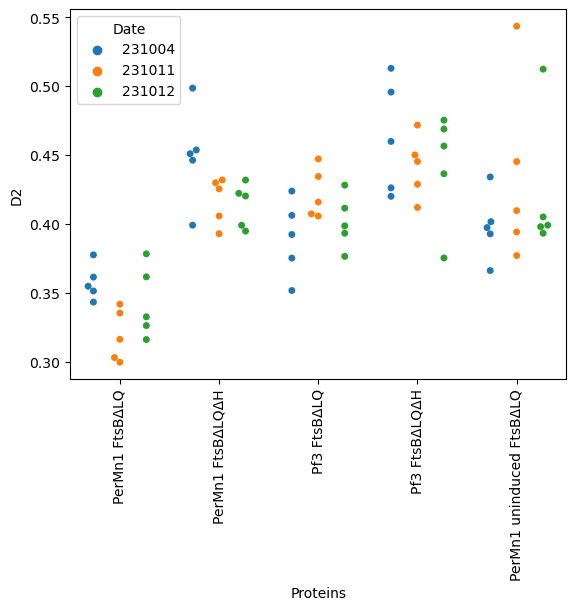

In [86]:
# Plot results for two population fit

import seaborn as sns

F1 = [ i[0] for i in params ]
D1 = [ i[1] for i in params ]
D2 = [ i[2] for i in params ]
s = [ i[3] for i in params ]

df['F1'] = F1
df['D1'] = D1
df['D2'] = D2
df['s'] = s
df['Proteins'] = df['Protein1'] + ' ' + df['Protein2']

# sns.barplot(data = df, x = 'Proteins', y = 'D2', hue='Date', dodge=True)

sns.swarmplot(data = df.query('FP=="mEos3.2"'), x = 'Proteins', y = 'D2', hue='Date', dodge=True)
plt.xticks(rotation=90)

print(df.s.median())
# plt.ylim([0.2, 0.5])
plt.show()

In [128]:
# Make all data into form that saspt can handle combining all movies from one day together

dates = df.Date.unique()

filepaths = []
conditions = []

df = df.query('not (FP=="mNeonGreen" & Date!="231012")')

for d in dates:
    ps = df.query('Date==@d').Proteins.unique()
    fps = df.query('Date==@d').FP.unique()

    for p in ps:
        for fp in fps:

    
            tracks = sum(df.query('Date==@d & Proteins==@p & FP==@fp').Tracks, [])

            if tracks:

                conditions.append(p + ' ' + fp)
                filepath = '_'.join([d,p.replace(' ','_'),fp]) + '.csv'
                filepaths.append('/home/zach/Desktop/microscope_data/FtsB_tracking/saspt/' + filepath)
            
                N = 0 # number of localizations
                for track in tracks:
                    N += track.shape[0]

                print(filepath, N)
                
                frames = np.zeros(N)
                ys = np.zeros(N)
                xs = np.zeros(N)
                trajectories = np.zeros(N)
                
                idx = 0
                
                for i in range(len(tracks)):
                    for j in range(len(tracks[i])):
                        xs[idx] = tracks[i][j][0]/100
                        ys[idx] = tracks[i][j][1]/100
                        trajectories[idx] = i
                        frames[idx] = j
                        idx += 1
        
                saspt_df = pd.DataFrame({'frame' : frames, 'y' : ys, 'x' : xs, 'trajectory' : trajectories})
                saspt_df.to_csv('/home/zach/Desktop/microscope_data/FtsB_tracking/saspt/' + filepath)

experiment_conditions = pd.DataFrame({'filepath' : filepaths, 'condition' : conditions})
experiment_conditions.to_csv('/home/zach/Desktop/microscope_data/FtsB_tracking/saspt/experiment_conditions.csv')

231004_PerMn1_FtsBΔLQ_mEos3.2.csv 93061
231004_PerMn1_FtsBΔLQΔH_mEos3.2.csv 59016
231004_Pf3_FtsBΔLQ_mEos3.2.csv 52892
231004_Pf3_FtsBΔLQΔH_mEos3.2.csv 49696
231004_PerMn1_uninduced_FtsBΔLQ_mEos3.2.csv 35898
231011_PerMn1_uninduced_FtsBΔLQ_mEos3.2.csv 36804
231011_PerMn1_FtsBΔLQ_mEos3.2.csv 49077
231011_PerMn1_FtsBΔLQΔH_mEos3.2.csv 42811
231011_Pf3_FtsBΔLQ_mEos3.2.csv 43410
231011_Pf3_FtsBΔLQΔH_mEos3.2.csv 48596
231012_PerMn1_uninduced_FtsBΔLQ_mEos3.2.csv 37285
231012_PerMn1_FtsBΔLQ_mEos3.2.csv 56597
231012_PerMn1_FtsBΔLQ_mNeonGreen.csv 30479
231012_PerMn1_FtsBΔLQΔH_mEos3.2.csv 53544
231012_PerMn1_FtsBΔLQΔH_mNeonGreen.csv 12857
231012_Pf3_FtsBΔLQ_mEos3.2.csv 57984
231012_Pf3_FtsBΔLQ_mNeonGreen.csv 21163
231012_Pf3_FtsBΔLQΔH_mEos3.2.csv 52089
231012_Pf3_FtsBΔLQΔH_mNeonGreen.csv 20951


In [130]:
df.query('FP=="mNeonGreen"').Protein1.unique()

array(['PerMn1', 'Pf3'], dtype=object)

In [118]:
len(df.query('not (FP=="mNeonGreen" & (Proteins=="PerMn1 uninduced FtsBΔLQ" or Date!="231012"))'))


95

In [120]:
df.query('Proteins=="PerMn1 uninduced FtsBΔLQ" & FP=="mNeonGreen"')

,Date,Path,Condition,Image file,IPTG,FP,Protein1,Protein2,Proteins,Tracks,maskImage,spotMedians,msd,msd_error,msd_N,sds,F1,D1,D2,s


In [98]:
saspt_df

,frame,y,x,trajectory
0,0.0,55.431826,112.091453,0.0
1,1.0,56.749777,112.041193,0.0
2,2.0,60.118640,112.522141,0.0
3,3.0,60.905049,112.714871,0.0
4,4.0,62.413756,110.405429,0.0
...,...,...,...,...
20946,0.0,70.900647,135.976362,5992.0
20947,1.0,71.245454,136.054701,5992.0
20948,2.0,72.190856,134.515335,5992.0
20949,0.0,117.618578,96.119531,5993.0
